#  Introduction

The notebook implements a solution to the problem of predicting the geographical origin of music. It was inspired by Fang Zhou's article "Predicting the Geographical Origin of Music".

An important part of this project was creation of dataset. Each country is represented by about 250-300 examples (consist of 323 features). The last 5 features are labels such as geographical coordinates and the name of country, subregion and region. Dataset was tested on 10 different classifiers. The best models were optimized. Results were compared to Fang Zhou's dataset metrics.

#  I. Data preparation
Data were extracted from analysis of recordings from CDs by reputable ethnic music publishers. Each CD was located in a separate folder within a country folder. Recordings were saved in WAV format which influenced the size of the database (~500 GB). 

A separate csv file has been created for each country. At the beginning the name of the country, subregion, region and geographical coordinates (for the capital) was set manually. The division into regions and subregions corresponds to the United Nations geoscheme. Then a 30-second excerpt with the highest energy (the climax of the piece) was cut out. Next the excerpts were analyzed by functions from Librosa library and some statistics were calculated.  

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import csv
import os

In [2]:
from scipy.signal import convolve
import soundfile as sf 

def extract_strongest_segment(filename, segment_duration=30):
    
    y, sr = librosa.load(filename, sr=44100)

    segment_samples = int(segment_duration * sr) # number of samples for a 30-second extract

    if len(y) < segment_samples:
        raise ValueError(f"The audio file is shorter than {segment_duration} seconds")

    y_squared = y**2 # signal amplification
    filter_kernel = np.ones(segment_samples) 

    # Energy calculation for each segment 
    segment_sound_energy = convolve(y_squared, filter_kernel, mode='valid')
    start_sample = np.argmax(segment_sound_energy)
    start_time_seconds = start_sample / sr

    # Cutting out the segment with the highest energy value
    strongest_segment = y[start_sample : start_sample + segment_samples]
    
    # Saving the segment on desktop
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop") 
    output_filename = os.path.join(desktop_path, "Temp_strongest_segment.wav")
    sf.write(output_filename, strongest_segment, sr)

In [3]:
# Header for csv file

feature_names =  ['mfcc_mean{}'.format(i+1) for i in range(20)] + ['mfcc_max{}'.format(i+1) for i in range(20)] \
                + ['mfcc_min{}'.format(i+1) for i in range(20)] + ['mfcc_median{}'.format(i+1) for i in range(20)] \
                + ['mfcc_std_dev{}'.format(i+1) for i in range(20)] + ['mfcc_skewness{}'.format(i+1) for i in range(20)] \
                + ['mfcc_kurtosis{}'.format(i+1) for i in range(20)] \
                + [ "spectral_centroid_mean", "spectral_centroid_max", "spectral_centroid_min", "spectral_centroid_median",\
                        "spectral_centroid_std_dev", "spectral_centroid_skewness", "spectral_centroid_kurtosis"] \
                + [ "flatness_mean", "flatness_max", "flatness_min", "flatness_median",\
                        "flatness_std_dev", "flatness_skewness", "flatness_kurtosis"] \
                + [ "zero_crossing_rate_mean", "zero_crossing_rate_max", "zero_crossing_rate_min", \
                   "zero_crossing_rate_median", "zero_crossing_rate_std_dev"] \
                + ['harmonics_mean{}'.format(i+1) for i in range(12)] + ['harmonic_max{}'.format(i+1) for i in range(12)] \
                + ['harmonic_std_dev{}'.format(i+1) for i in range(12)] \
                + ['harmonic_skewness{}'.format(i+1) for i in range(12)] + ['harmonic_kurtosis{}'.format(i+1) for i in range(12)] \
                + ['chroma_mean{}'.format(i+1)for i in range(12)] + ['chroma_median{}'.format(i+1) for i in range(12)] \
                + ['chroma_std_dev{}'.format(i+1) for i in range(12)] + ['chroma_skewness{}'.format(i+1) for i in range(12)] \
                + ['chroma_kurtosis{}'.format(i+1) for i in range(12)] \
                + ['interval_{}'.format(i+1) for i in range(11)] + ["chroma_contrast"]\
                + ['tempo', 'onset_rate', 'onset_intervals_mean', 'onset_intervals_median', 'onset_intervals_std_dev', \
                   'onset_intervals_skewness', 'onset_intervals_kurtosis', 'onset_strength_mean', 'onset_strength_std_dev', \
                   'onset_strength_max', 'area_under_curve', 'dynamic_range'] \
                + ['tempogram_ratio{}'.format(i+1) for i in range(12)] \
                + ['album', 'track', 'latitude', 'longitude', 'region', 'subregion', 'country']


In [4]:
# Feature extraction for a country

data_country_folder = r"{path_to_data_country_folder}" # fill path to folder with recordings from a country

output_csv_path = r'{path_to_output_csv}\{country_name}.csv' # fill path for output csv files

country = "Greece" # fill information about country
subregion = "Southern Europe"
region = "Europe"
latitude = 37.59 # S -> '-'; N -> '+'
longitude = 23.44 # W -> '-'; E -> '+'

country_features = np.array ([latitude, longitude, region, subregion, country])

with open(output_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(feature_names) # setting header
   
for subdir, _, files in os.walk(data_country_folder):
    for file in files:

        if file.endswith(".wav"):
            full_file_path = os.path.join(subdir, file)               
            file_name_without_extension = os.path.splitext(file)[0]

            file_features = np.array([os.path.basename(subdir), file_name_without_extension])

            extract_strongest_segment(full_file_path)
            current_track = r"{path_to_desktop}\Temp_strongest_segment.wav" # fill path to desktop

            y, sr = librosa.load(current_track)

            # TIMBRE
            ## MFCC
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            mfcc = mfcc.T

            mfcc_mean = np.mean(mfcc, axis=0)
            mfcc_max = np.max(mfcc, axis=0)
            mfcc_min = np.min(mfcc, axis=0)
            mfcc_median = np.median(mfcc, axis=0)
            mfcc_std_dev = np.std(mfcc,axis=0)
            mfcc_skewness = skew(mfcc, axis=0) 
            mfcc_kurtosis = kurtosis(mfcc, axis=0)

            ## Spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

            spectral_centroid_mean = np.mean(spectral_centroid)
            spectral_centroid_max = np.max(spectral_centroid)
            spectral_centroid_min = np.min(spectral_centroid)
            spectral_centroid_median = np.median(spectral_centroid)
            spectral_centroid_std_dev = np.std(spectral_centroid)
            spectral_centroid_skewness = skew(spectral_centroid) 
            spectral_centroid_kurtosis = kurtosis(spectral_centroid)

            spectral_centroid_features = np.array([spectral_centroid_mean,spectral_centroid_max,spectral_centroid_min,spectral_centroid_median,\
                                                  spectral_centroid_std_dev,spectral_centroid_skewness,spectral_centroid_kurtosis])


            ## Spectral flatness
            flatness = librosa.feature.spectral_flatness(y=y)[0]

            flatness_mean = np.mean(flatness)
            flatness_max = np.max(flatness)
            flatness_min = np.min(flatness)
            flatness_median = np.median(flatness)
            flatness_std_dev = np.std(flatness)
            flatness_skewness = skew(flatness) 
            flatness_kurtosis = kurtosis(flatness)

            flatness_features = np.array([flatness_mean, flatness_max, flatness_min, flatness_median,\
                                                  flatness_std_dev, flatness_skewness, flatness_kurtosis])

            ## Zero-crossing rate
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

            zero_crossing_rate_mean = np.mean(zero_crossing_rate)
            zero_crossing_rate_max = np.max(zero_crossing_rate)
            zero_crossing_rate_min = np.min(zero_crossing_rate)
            zero_crossing_rate_median = np.median(zero_crossing_rate)
            zero_crossing_rate_std_dev = np.std(zero_crossing_rate)  

            zrc_features = np.array([zero_crossing_rate_mean, zero_crossing_rate_max, zero_crossing_rate_min, 
                     zero_crossing_rate_median, zero_crossing_rate_std_dev])

            ## Harmony
            f0, voicing, voicing_p = librosa.pyin(y=y, sr=sr, fmin=200, fmax=700)
            S = np.abs(librosa.stft(y))
            freqs = librosa.fft_frequencies(sr=sr)
            harmonics = np.arange(1, 13)
            f0_harm = librosa.f0_harmonics(S, freqs=freqs, f0=f0, harmonics=harmonics)

            harmonics_mean_list = []
            harmonic_max_list = []
            harmonic_median_list = []
            harmonic_std_dev_list = []
            harmonic_skewness_list = []
            harmonic_kurtosis_list = []

            for harmonic in f0_harm:
                harmonics_mean_list.append(np.mean(harmonic))
                harmonic_max_list.append(np.max(harmonic))
                harmonic_median_list.append(np.median(harmonic))
                harmonic_std_dev_list.append(np.std(harmonic))
                harmonic_skewness_list.append(skew(harmonic))
                harmonic_kurtosis_list.append(kurtosis(harmonic))

            harmonics_mean = np.array(harmonics_mean_list)
            harmonic_max = np.array(harmonic_max_list)
            harmonic_std_dev = np.array(harmonic_std_dev_list)
            harmonic_skewness = np.array(harmonic_skewness_list)
            harmonic_kurtosis = np.array(harmonic_kurtosis_list)

            harmony_features = np.concatenate((harmonics_mean, harmonic_max, harmonic_std_dev, 
                                          harmonic_skewness, harmonic_kurtosis))

            # MELODY
            ## Chroma
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma = chroma.T

            chroma_mean = np.mean(chroma, axis=0)
            chroma_median = np.median(chroma, axis=0)
            chroma_std_dev = np.std(chroma,axis=0)
            chroma_skewness = skew(chroma, axis=0) 
            chroma_kurtosis = kurtosis(chroma, axis=0)

            ## Pitch intervals
            yin = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

            notes = np.round(librosa.hz_to_midi(yin))
            pitch_classes = np.mod(notes, 12) # normalization to one octave

            intervals =[]
            for i in range(1, len(pitch_classes)):
                if pitch_classes[i] != pitch_classes[i-1]:
                    interval = np.abs(pitch_classes[i] - pitch_classes[i-1])
                    intervals.append(interval)

            intervals_counter = np.bincount(intervals, minlength=12)[1:12]
            interval_features = [interval/len(intervals) for interval in intervals_counter]

            ## Chroma contrast
            pitch_classes_counter = np.bincount(pitch_classes.astype(int), minlength=12)
            sorted_pitch_classes = sorted(pitch_classes_counter, reverse=True)
            sum_top_6 = sum(sorted_pitch_classes[:6]) # the sum of the six most frequently occurring sound classes 
            sum_remaining = sum(sorted_pitch_classes[6:]) # the sum of other classes
            
            if sum_remaining != 0:  
                chroma_contrast = sum_top_6 / sum_remaining
            else:
                chroma_contrast = 0.0

            chroma_contrast = np.array([chroma_contrast])

            # RHYTHM 
            ## Tempo
            tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

            ## Onset detection
            onsets = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
            onset_times = librosa.frames_to_time(onsets, sr=sr)
            onset_intervals = np.diff(onset_times)

            ## Onset strength
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)

            ## Features from onset detection
            total_onsets = len(onsets)
            onset_rate = total_onsets / librosa.get_duration(y=y, sr=sr)
            onset_intervals_mean = np.mean(onset_intervals)
            onset_intervals_median = np.median(onset_intervals)
            onset_intervals_std_dev = np.std(onset_intervals)
            onset_intervals_skewness = skew(onset_intervals, axis=0) 
            onset_intervals_kurtosis = kurtosis(onset_intervals, axis=0)

            onset_strength_mean = np.mean(onset_env)
            onset_strength_std_dev = np.std(onset_env)
            onset_strength_max = np.max(onset_env)
            area_under_curve = np.sum(onset_env)
            dynamic_range = onset_strength_max - np.min(onset_env)

            times = librosa.times_like(onset_env, sr=sr)
            temporal_centroid = np.sum(times * onset_env) / np.sum(onset_env)

            onset_features = [tempo, onset_rate, onset_intervals_mean, onset_intervals_median, \
                              onset_intervals_std_dev, onset_intervals_skewness, onset_intervals_kurtosis, \
                              onset_strength_mean, onset_strength_std_dev, onset_strength_max, \
                              area_under_curve, dynamic_range]

            ## Tempogram ratio
            tempogram = librosa.feature.tempogram(y=y, sr=sr)
            tempogram_ratio = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
            tempogram_ratio_avg = np.mean(tempogram_ratio, axis=1)
            tempogram_ratio_avg_mean= np.mean(tempogram_ratio)
            tempogram_ratio_avg = tempogram_ratio_avg/tempogram_ratio_avg_mean # ratio of the average value for each index to the average


        
            # Concatenation of all features
            features = np.concatenate((mfcc_mean, mfcc_max, mfcc_min, mfcc_median, mfcc_std_dev, mfcc_skewness, mfcc_kurtosis,
                                       spectral_centroid_features, flatness_features, zrc_features, harmony_features,
                                      chroma_mean, chroma_median, chroma_std_dev, chroma_skewness, chroma_kurtosis,
                                       interval_features, chroma_contrast, onset_features, tempogram_ratio_avg,
                                       file_features, country_features))



            with open(output_csv_path, 'a', newline='', encoding='utf-8') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(features)

In [6]:
dataset_country = pd.read_csv(output_csv_path)
dataset_country.head() 

,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,...,tempogram_ratio11,tempogram_ratio12,tempogram_ratio13,album,track,latitude,longitude,continent,region,country
0,-155.619900,101.231766,-12.839704,32.495285,3.268015,5.420455,9.362135,12.537017,-2.968386,-1.295529,...,1.061667,0.842619,0.881073,Grecja - Asie Mineure et Constantinople,Tatavliano Hasapiko,37.59,23.44,Europe,Southern Europe,Greece
1,-127.702965,114.631966,-15.141718,25.476702,-7.223075,10.671487,1.320467,5.614412,-7.564149,0.680998,...,0.957869,0.842187,0.797875,Grecja - Asie Mineure et Constantinople,Emorfi tatavliani,37.59,23.44,Europe,Southern Europe,Greece
2,-102.990060,103.105610,-20.514761,32.418865,-0.728835,12.424837,1.885982,4.115909,-6.416043,0.310990,...,0.915192,0.838410,0.729811,Grecja - Asie Mineure et Constantinople,Ta paidia tis geitonias sou,37.59,23.44,Europe,Southern Europe,Greece
3,-103.249920,101.531080,-14.779862,29.140474,-2.948120,13.692292,-1.022193,7.149019,-5.406279,2.910137,...,0.948887,0.879765,0.831786,Grecja - Asie Mineure et Constantinople,I Elli,37.59,23.44,Europe,Southern Europe,Greece
4,-87.242584,100.451210,-15.845111,30.194098,-4.836621,15.566210,-6.780961,4.395852,-3.440731,5.902769,...,0.953723,0.891818,0.787787,Grecja - Asie Mineure et Constantinople,Matia mou,37.59,23.44,Europe,Southern Europe,Greece


#### After feature extraction for each country and verifying that all values are appropriate all csv files were merged into one: [Dataset.csv](https://drive.google.com/file/d/18QaBijQ0hzVm1av_7fYISco03WWjz60u/view?usp=sharing)

In [8]:
# Number of examples from each country

from collections import defaultdict

final_dataset_path = r"{path_to_dataset}\Dataset.csv" # fill path to desktop
country_counts = defaultdict(int)

with open(final_dataset_path, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # removing header

    for row in reader:
        country = row[-1]
        country_counts[country] += 1

for country, count in country_counts.items():
    print(f'{country}: {count}')

Afghanistan: 274
Argentina: 309
Armenia: 329
Australia: 249
Azerbaijan: 276
Brazil: 301
Bulgaria: 297
Cambodia: 234
Cameroon: 292
Canada: 290
Central African Republic: 245
China: 323
Colombia: 262
Cuba: 330
Democratic Republic of the Congo: 334
France: 304
Ghana: 247
Greece: 314
India: 325
Indonesia: 318
Iran: 288
Ireland: 272
Italy: 330
Japan: 287
Kenya: 324
Korea: 289
Madagascar: 284
Mexico: 323
Mongolia: 286
Morocco: 288
Papua New Guinea: 253
Peru: 333
Portugal: 312
Romania: 291
Russia(Siberia): 334
Russia: 268
Scotland: 227
Spain: 284
Trinidad and Tobago: 256
Turkey: 323
United States of America: 326
Uzbekistan: 255
Venezuela: 247
Vietnam: 327


# II. Analysis of some functions based on specific examples
Some features clearly show the difference between traditional music in different countries. Some audio examples are available under [this link](https://drive.google.com/drive/folders/1AVd1nPgDkVjFM66hLyykAjxBYRvwx8Ki?usp=sharing)
## Zero-crossing rate
Zero-crossing rate determines the frequency of change of the signal value from positive to negative and vice versa. In addition, the ZCR can determine the noise of the recording - it usually reaches much higher values if the signal is noisy. Particularly useful statistic to describe the ZCR is standard deviation.

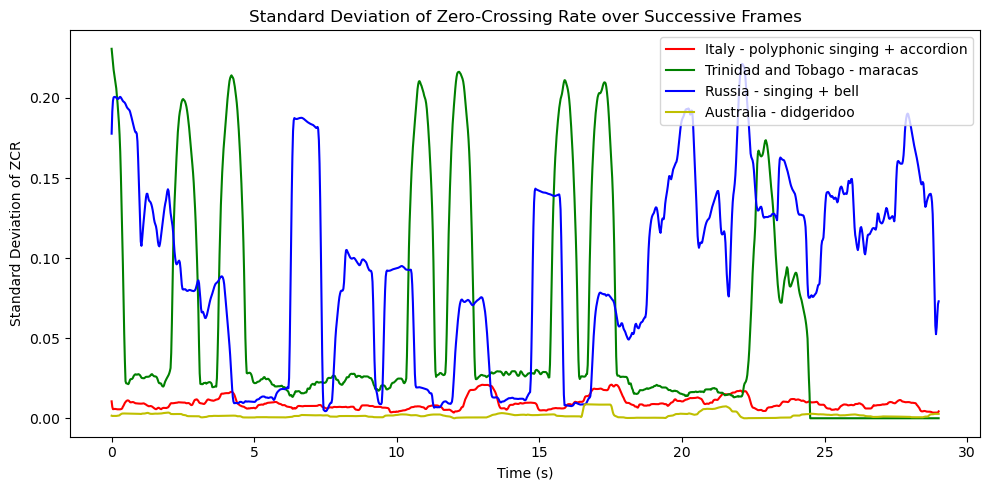

In [74]:
filenames = [ 
    r"{path_to_tracks}\track1.wav", # fill path to downloaded recordings
    r"{path_to_tracks}\track2.wav",
    r"{path_to_tracks}\track3.wav",
    r"{path_to_tracks}\track4.wav"
]


def compute_zcr(filename):
    extract_strongest_segment(filename)
    temp_file = r"{path_to_desktop}\Temp_strongest_segment.wav" # fill path to desktop
    y, sr= librosa.load(temp_file)
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    return zcr

def compute_std_over_frames(zcrs, frame_size):
    num_frames = len(zcrs) - frame_size + 1
    std_values = np.zeros(num_frames)
    for i in range(num_frames):
        std_values[i] = np.std(zcrs[i:i+frame_size])
    return std_values

frame_size = 43  
hop_length = 512  
colors = ['r', 'g', 'b', 'y'] 
labels = ['Italy - polyphonic singing + accordion', 'Trinidad and Tobago - maracas','Russia - singing + bell', 
          'Australia - didgeridoo'] 

plt.figure(figsize=(8, 4))

for i, filename in enumerate(filenames):
    zcr = compute_zcr(filename)
    std_values = compute_std_over_frames(zcr, frame_size)

    # Calculate times for each frame
    times = np.arange(len(std_values)) * hop_length / sr
    
    plt.plot(times, std_values, color=colors[i], label=labels[i])

plt.ylabel('Standard Deviation of ZCR')
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()
plt.show()

Australian didgeridoo reached values close to 0. The sound produced by this instrument is stable and does not change pitch or intensity abruptly. Slightly higher standard deviation value was achieved by the Italian polyphonic singing accompanied by an accordion. Accompaniment of the instrument may have caused consistent distribution (without unexpected peaks). Standard deviation of maracas is slightly higher than in the other examples and has some surprising peaks. After analysing the audio file it turned out that recording is a compilation of short extracts separated by silence. The recording of Russian monophonic singing has the most varied course of standard deviation. Peaks can be divided into two groups. Sharp peaks occur when bell is used. Peaks with a rectangular shape occur when singer breathes.

## Pitch classes
Traditional music is often based on musical scales. These are series of sounds arranged according to fixed patterns defining distances between successive sounds.

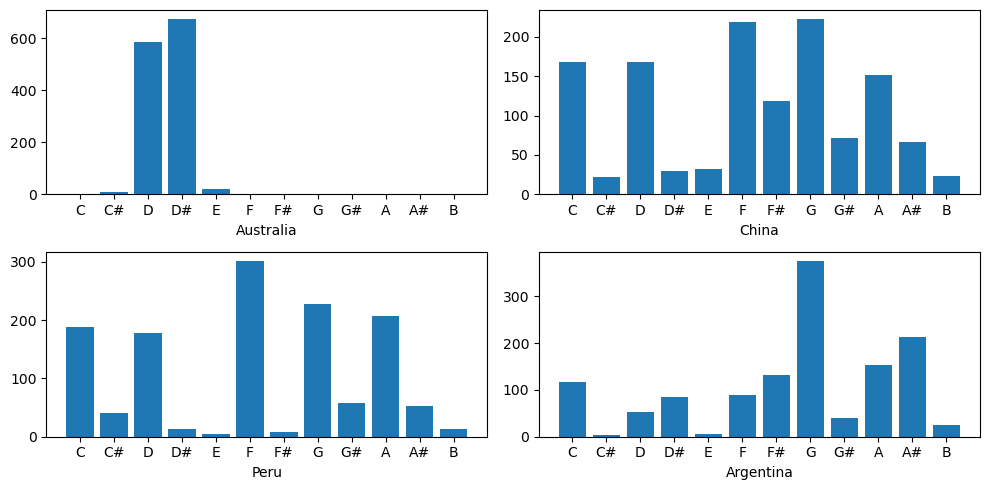

In [90]:
filenames = [
    r"{path_to_tracks}\track4.wav", # fill path to downloaded recordings
    r"{path_to_tracks}\track5.wav",
    r"{path_to_tracks}\track6.wav",
    r"{path_to_tracks}\track7.wav"
]

titles = [
    "Australia",
    "China",
    "Peru",
    "Argentina"
]

def compute_pitch_classes(filename):
    y, sr = librosa.load(filename)
    yin = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

    notes = np.round(librosa.hz_to_midi(yin))
    pitch_classes = np.mod(notes, 12)  # normalization to one octave

    intervals = []
    for i in range(1, len(pitch_classes)):
        if pitch_classes[i] != pitch_classes[i - 1]:
            interval = np.abs(pitch_classes[i] - pitch_classes[i - 1])
            intervals.append(interval)

    intervals_counter = np.bincount(intervals, minlength=12)[1:12]

    pitch_classes_counter = np.bincount(pitch_classes.astype(int), minlength=12)
    sorted_pitch_classes = sorted(pitch_classes_counter, reverse=True)

    return pitch_classes_counter

file_results = []
for file in filenames:
    extract_strongest_segment(file)
    temp_file = r"{path_to_desktop}\Temp_strongest_segment.wav" # fill path to desktop
    pitch_classes_counter = compute_pitch_classes(temp_file)
    file_results.append((pitch_classes_counter))
    
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

for idx, (pitch_classes_counter) in enumerate(file_results, 1):
    ax = axes[(idx-1)//2, (idx-1)%2] 
    ax.bar(range(12), pitch_classes_counter, tick_label=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    ax.set_xlabel(titles[idx-1])

plt.tight_layout()
plt.show()

Traditional Chinese and Peruvian music is based on pentatonic scale. Argentine tango is built on a seven-note minor scale. The example is dominated by G sound because the piece is in G minor. The last example is solo performed on didgeridoo. Sound produced by this instrument oscillates between adjacent notes.

# III. Classification
The first stage of the experiment involved a preliminary evaluation of classifiers performance. A task was to determine the place of origin of some traditional music pieces. Calculations were made for 3 categories: region, subregion and country. Analysis used all attributes that had been scaled using StandardScaler().
Model quality was assesed using cross-validation. Columns with geographical coordinates and names of songs and albums have been removed from the dataset.

## 1. Evaluation of classifiers

In [17]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

dataset = pd.read_csv('{path_to_dataset}\DATASET.csv') # c
dataset = dataset.drop(dataset.columns[-7:-3], axis=1) # removing coordinates and names of songs and albums

columns_to_drop = [-2, -3] # select two columns to drop: -1 (country), -2 (subregion), -3 (region)
dataset = dataset.drop(dataset.columns[columns_to_drop], axis=1)

# Select proper set of features:
X = dataset.iloc[:, :-1]  # all features
# X = data.iloc[:, :219] # timbre
# X = data.iloc[:, 219:291] # melody
# X = data.iloc[:, -26:-1] # rhythm
# X = data.iloc[:, :291] # timbre + rhythm
# X1 = data.iloc[:, :220]  # timbre + rhythm
# X2 = data.iloc[:, -26:-1]  # timbre + rhythm
# X = pd.concat([X1, X2], axis=1) # timbre + rhythm
# X = data.iloc[:, 220:-1] # melody + rhythm
y = dataset.iloc[:, -1]   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [115]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='uniform')
scores = cross_val_score(dummy_clf, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for Dummy classifier: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for Dummy Classifier: 2.24% (+/- 0.53%)


In [116]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
scores = cross_val_score(nb, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for Gaussian Naive Bayes classifier: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for Gaussian Naive Bayes classifier: 21.97% (+/- 1.40%)


In [117]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for Decision Tree: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for Decision Tree: 18.14% (+/- 0.54%)


In [118]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
scores = cross_val_score(sgd, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for SGD classifier: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for SGD classifier: 28.33% (+/- 1.13%)


In [122]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for Logistic Regression: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for Logistic Regression: 36.84% (+/- 1.10%)


In [9]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(penalty = 'l2', C = 1, loss = 'squared_hinge', dual = False)
scores = cross_val_score(lsvc, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for Linear SVC: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for Linear SVC: 36.29% (+/- 1.23%)


In [124]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for K-Nearest Neighbors: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for K-Nearest Neighbors: 45.82% (+/- 1.11%)


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for Random Forest Classifier: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for Linear SVC: 54,13% (+/- 1.15%)


In [148]:
from sklearn.svm import SVC

svm = SVC()  
scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='accuracy')
print(f"Accuracy for Support Vector Machine: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)")

Accuracy for Support Vector Machine: 51.31% (+/- 2.13%)


In [25]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, train_test_split

X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_temp, X_test, y_temp_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

def create_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_temp.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

n_folds = 10
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
fold = 0
history = []
accuracies = []  

for train_index, val_index in kf.split(X_temp, y_temp_encoded):
    fold += 1
    X_train, X_val = X_temp[train_index], X_temp[val_index]
    y_train, y_val = y_temp_encoded[train_index], y_temp_encoded[val_index]
    
    model = create_model()
    
    print(f"Training on fold {fold}")
    
    checkpoint = ModelCheckpoint(f'best_model_fold_{fold}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint])
    history.append(hist)
    
    best_model = load_model(f'best_model_fold_{fold}.h5')
    _, accuracy = best_model.evaluate(X_val, y_val, verbose=0)
    accuracies.append(accuracy)
    print(f"Accuracy for fold {fold}: {accuracy * 100:.2f}%")

average_accuracy = np.mean(accuracies)
average_std = np.std(accuracies)
print(f"Accuracy for Neural Networks: {average_accuracy*100:.2f}% (+/- {average_std*100:.2f}%)")

Training on fold 1
Epoch 1/50
252/254 [============================>.] - ETA: 0s - loss: 2.9338 - accuracy: 0.2550
Epoch 1: val_accuracy improved from -inf to 0.38069, saving model to best_model_fold_1.h5
254/254 [==============================] - 5s 13ms/step - loss: 2.9308 - accuracy: 0.2556 - val_loss: 2.3829 - val_accuracy: 0.3807
Epoch 2/50
  6/254 [..............................] - ETA: 2s - loss: 1.9428 - accuracy: 0.4948

C:\Users\Pawel\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/254 [============================>.] - ETA: 0s - loss: 1.8981 - accuracy: 0.4883
Epoch 2: val_accuracy improved from 0.38069 to 0.44839, saving model to best_model_fold_1.h5
254/254 [==============================] - 3s 10ms/step - loss: 1.8998 - accuracy: 0.4876 - val_loss: 2.1030 - val_accuracy: 0.4484
Epoch 3/50
254/254 [==============================] - ETA: 0s - loss: 1.3633 - accuracy: 0.6272
Epoch 3: val_accuracy improved from 0.44839 to 0.47392, saving model to best_model_fold_1.h5
254/254 [==============================] - 3s 11ms/step - loss: 1.3633 - accuracy: 0.6272 - val_loss: 2.0400 - val_accuracy: 0.4739
Epoch 4/50
253/254 [============================>.] - ETA: 0s - loss: 0.9848 - accuracy: 0.7279
Epoch 4: val_accuracy did not improve from 0.47392
254/254 [==============================] - 2s 9ms/step - loss: 0.9850 - accuracy: 0.7278 - val_loss: 2.0294 - val_accuracy: 0.4706
Epoch 5/50
250/254 [============================>.] - ETA: 0s - loss: 0.6617 - accuracy: 0.

252/254 [============================>.] - ETA: 0s - loss: 3.7903e-04 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.57603
254/254 [==============================] - 2s 8ms/step - loss: 3.7920e-04 - accuracy: 1.0000 - val_loss: 2.9419 - val_accuracy: 0.5716
Epoch 31/50
250/254 [============================>.] - ETA: 0s - loss: 3.2935e-04 - accuracy: 1.0000
Epoch 31: val_accuracy did not improve from 0.57603
254/254 [==============================] - 2s 9ms/step - loss: 3.2917e-04 - accuracy: 1.0000 - val_loss: 2.9669 - val_accuracy: 0.5749
Epoch 32/50
254/254 [==============================] - ETA: 0s - loss: 2.8497e-04 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.57603
254/254 [==============================] - 2s 9ms/step - loss: 2.8497e-04 - accuracy: 1.0000 - val_loss: 2.9885 - val_accuracy: 0.5760
Epoch 33/50
251/254 [============================>.] - ETA: 0s - loss: 2.4656e-04 - accuracy: 1.0000
Epoch 33: val_accuracy improved from 0.57603 to

252/254 [============================>.] - ETA: 0s - loss: 0.2634 - accuracy: 0.9349
Epoch 7: val_accuracy improved from 0.48613 to 0.49057, saving model to best_model_fold_2.h5
254/254 [==============================] - 2s 9ms/step - loss: 0.2637 - accuracy: 0.9348 - val_loss: 2.3989 - val_accuracy: 0.4906
Epoch 8/50
253/254 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9749
Epoch 8: val_accuracy improved from 0.49057 to 0.51054, saving model to best_model_fold_2.h5
254/254 [==============================] - 2s 9ms/step - loss: 0.1369 - accuracy: 0.9749 - val_loss: 2.5192 - val_accuracy: 0.5105
Epoch 9/50
249/254 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9858
Epoch 9: val_accuracy improved from 0.51054 to 0.51942, saving model to best_model_fold_2.h5
254/254 [==============================] - 2s 8ms/step - loss: 0.0845 - accuracy: 0.9858 - val_loss: 2.5809 - val_accuracy: 0.5194
Epoch 10/50
249/254 [============================>.

Epoch 35/50
251/254 [============================>.] - ETA: 0s - loss: 2.2338e-04 - accuracy: 1.0000
Epoch 35: val_accuracy improved from 0.55272 to 0.55494, saving model to best_model_fold_2.h5
254/254 [==============================] - 2s 9ms/step - loss: 2.2353e-04 - accuracy: 1.0000 - val_loss: 3.7808 - val_accuracy: 0.5549
Epoch 36/50
252/254 [============================>.] - ETA: 0s - loss: 2.0000e-04 - accuracy: 1.0000
Epoch 36: val_accuracy did not improve from 0.55494
254/254 [==============================] - 3s 10ms/step - loss: 1.9999e-04 - accuracy: 1.0000 - val_loss: 3.7954 - val_accuracy: 0.5549
Epoch 37/50
253/254 [============================>.] - ETA: 0s - loss: 1.7899e-04 - accuracy: 1.0000
Epoch 37: val_accuracy improved from 0.55494 to 0.55605, saving model to best_model_fold_2.h5
254/254 [==============================] - 2s 9ms/step - loss: 1.7919e-04 - accuracy: 1.0000 - val_loss: 3.8108 - val_accuracy: 0.5560
Epoch 38/50
248/254 [============================>.

Epoch 12/50
250/254 [============================>.] - ETA: 0s - loss: 0.3494 - accuracy: 0.8964
Epoch 12: val_accuracy did not improve from 0.53556
254/254 [==============================] - 2s 9ms/step - loss: 0.3510 - accuracy: 0.8956 - val_loss: 3.1106 - val_accuracy: 0.4722
Epoch 13/50
248/254 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.9056
Epoch 13: val_accuracy did not improve from 0.53556
254/254 [==============================] - 2s 9ms/step - loss: 0.3000 - accuracy: 0.9057 - val_loss: 2.9690 - val_accuracy: 0.5000
Epoch 14/50
251/254 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9697
Epoch 14: val_accuracy improved from 0.53556 to 0.54556, saving model to best_model_fold_3.h5
254/254 [==============================] - 2s 9ms/step - loss: 0.1079 - accuracy: 0.9694 - val_loss: 2.9198 - val_accuracy: 0.5456
Epoch 15/50
251/254 [============================>.] - ETA: 0s - loss: 0.0400 - accuracy: 0.9913
Epoch 15: val_accurac

Epoch 40/50
251/254 [============================>.] - ETA: 0s - loss: 1.0615e-04 - accuracy: 1.0000
Epoch 40: val_accuracy did not improve from 0.59222
254/254 [==============================] - 2s 9ms/step - loss: 1.0629e-04 - accuracy: 1.0000 - val_loss: 3.2909 - val_accuracy: 0.5889
Epoch 41/50
254/254 [==============================] - ETA: 0s - loss: 9.4884e-05 - accuracy: 1.0000
Epoch 41: val_accuracy did not improve from 0.59222
254/254 [==============================] - 2s 9ms/step - loss: 9.4884e-05 - accuracy: 1.0000 - val_loss: 3.3106 - val_accuracy: 0.5889
Epoch 42/50
254/254 [==============================] - ETA: 0s - loss: 8.4748e-05 - accuracy: 1.0000
Epoch 42: val_accuracy did not improve from 0.59222
254/254 [==============================] - 2s 9ms/step - loss: 8.4748e-05 - accuracy: 1.0000 - val_loss: 3.3297 - val_accuracy: 0.5922
Epoch 43/50
250/254 [============================>.] - ETA: 0s - loss: 7.5244e-05 - accuracy: 1.0000
Epoch 43: val_accuracy did not impr

254/254 [==============================] - 2s 8ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 3.2465 - val_accuracy: 0.5122
Epoch 18/50
250/254 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9999
Epoch 18: val_accuracy did not improve from 0.51222
254/254 [==============================] - 2s 10ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 3.2605 - val_accuracy: 0.5122
Epoch 19/50
248/254 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994
Epoch 19: val_accuracy improved from 0.51222 to 0.51889, saving model to best_model_fold_4.h5
254/254 [==============================] - 2s 9ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 3.2755 - val_accuracy: 0.5189
Epoch 20/50
248/254 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9997
Epoch 20: val_accuracy did not improve from 0.51889
254/254 [==============================] - 2s 9ms/step - loss: 0.0041 - accuracy: 0.9998 - val_loss: 3.2968 - val_acc

Epoch 46/50
254/254 [==============================] - ETA: 0s - loss: 5.0032e-05 - accuracy: 1.0000
Epoch 46: val_accuracy did not improve from 0.52333
254/254 [==============================] - 2s 8ms/step - loss: 5.0032e-05 - accuracy: 1.0000 - val_loss: 3.8945 - val_accuracy: 0.5189
Epoch 47/50
253/254 [============================>.] - ETA: 0s - loss: 4.4611e-05 - accuracy: 1.0000
Epoch 47: val_accuracy did not improve from 0.52333
254/254 [==============================] - 2s 9ms/step - loss: 4.4592e-05 - accuracy: 1.0000 - val_loss: 3.9199 - val_accuracy: 0.5178
Epoch 48/50
254/254 [==============================] - ETA: 0s - loss: 3.9665e-05 - accuracy: 1.0000
Epoch 48: val_accuracy did not improve from 0.52333
254/254 [==============================] - 3s 10ms/step - loss: 3.9665e-05 - accuracy: 1.0000 - val_loss: 3.9416 - val_accuracy: 0.5189
Epoch 49/50
253/254 [============================>.] - ETA: 0s - loss: 3.5284e-05 - accuracy: 1.0000
Epoch 49: val_accuracy improved fr

Epoch 23/50
251/254 [============================>.] - ETA: 0s - loss: 6.7951e-04 - accuracy: 1.0000
Epoch 23: val_accuracy did not improve from 0.54222
254/254 [==============================] - 2s 8ms/step - loss: 6.7930e-04 - accuracy: 1.0000 - val_loss: 3.2281 - val_accuracy: 0.5422
Epoch 24/50
253/254 [============================>.] - ETA: 0s - loss: 6.0459e-04 - accuracy: 1.0000
Epoch 24: val_accuracy improved from 0.54222 to 0.54333, saving model to best_model_fold_5.h5
254/254 [==============================] - 2s 8ms/step - loss: 6.0465e-04 - accuracy: 1.0000 - val_loss: 3.2492 - val_accuracy: 0.5433
Epoch 25/50
252/254 [============================>.] - ETA: 0s - loss: 5.3839e-04 - accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 0.54333
254/254 [==============================] - 2s 9ms/step - loss: 5.3963e-04 - accuracy: 1.0000 - val_loss: 3.2721 - val_accuracy: 0.5367
Epoch 26/50
253/254 [============================>.] - ETA: 0s - loss: 4.8241e-04 - accuracy: 

Accuracy for fold 5: 54.89%
Training on fold 6
Epoch 1/50
253/254 [============================>.] - ETA: 0s - loss: 2.9143 - accuracy: 0.2552
Epoch 1: val_accuracy improved from -inf to 0.37111, saving model to best_model_fold_6.h5
254/254 [==============================] - 4s 10ms/step - loss: 2.9144 - accuracy: 0.2551 - val_loss: 2.4051 - val_accuracy: 0.3711
Epoch 2/50
252/254 [============================>.] - ETA: 0s - loss: 1.8763 - accuracy: 0.4980
Epoch 2: val_accuracy improved from 0.37111 to 0.44556, saving model to best_model_fold_6.h5
254/254 [==============================] - 2s 8ms/step - loss: 1.8747 - accuracy: 0.4983 - val_loss: 2.1228 - val_accuracy: 0.4456
Epoch 3/50
250/254 [============================>.] - ETA: 0s - loss: 1.3288 - accuracy: 0.6309
Epoch 3: val_accuracy improved from 0.44556 to 0.48111, saving model to best_model_fold_6.h5
254/254 [==============================] - 2s 8ms/step - loss: 1.3300 - accuracy: 0.6301 - val_loss: 2.0458 - val_accuracy: 0.

Epoch 28/50
250/254 [============================>.] - ETA: 0s - loss: 4.9959e-04 - accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 0.59111
254/254 [==============================] - 3s 10ms/step - loss: 5.0016e-04 - accuracy: 1.0000 - val_loss: 2.9306 - val_accuracy: 0.5911
Epoch 29/50
252/254 [============================>.] - ETA: 0s - loss: 4.3311e-04 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.59111
254/254 [==============================] - 2s 8ms/step - loss: 4.3283e-04 - accuracy: 1.0000 - val_loss: 2.9597 - val_accuracy: 0.5900
Epoch 30/50
249/254 [============================>.] - ETA: 0s - loss: 3.7342e-04 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.59111
254/254 [==============================] - 3s 10ms/step - loss: 3.7357e-04 - accuracy: 1.0000 - val_loss: 2.9919 - val_accuracy: 0.5844
Epoch 31/50
251/254 [============================>.] - ETA: 0s - loss: 3.2370e-04 - accuracy: 1.0000
Epoch 31: val_accuracy did not im

Epoch 6/50
253/254 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.9013
Epoch 6: val_accuracy improved from 0.47333 to 0.49111, saving model to best_model_fold_7.h5
254/254 [==============================] - 2s 8ms/step - loss: 0.3799 - accuracy: 0.9014 - val_loss: 2.2297 - val_accuracy: 0.4911
Epoch 7/50
249/254 [============================>.] - ETA: 0s - loss: 0.2303 - accuracy: 0.9472
Epoch 7: val_accuracy improved from 0.49111 to 0.50222, saving model to best_model_fold_7.h5
254/254 [==============================] - 2s 7ms/step - loss: 0.2319 - accuracy: 0.9464 - val_loss: 2.2832 - val_accuracy: 0.5022
Epoch 8/50
248/254 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9690
Epoch 8: val_accuracy did not improve from 0.50222
254/254 [==============================] - 2s 7ms/step - loss: 0.1480 - accuracy: 0.9688 - val_loss: 2.4281 - val_accuracy: 0.4889
Epoch 9/50
251/254 [============================>.] - ETA: 0s - loss: 0.0953 - acc

Epoch 34/50
252/254 [============================>.] - ETA: 0s - loss: 2.0967e-04 - accuracy: 1.0000
Epoch 34: val_accuracy did not improve from 0.54333
254/254 [==============================] - 2s 10ms/step - loss: 2.0955e-04 - accuracy: 1.0000 - val_loss: 3.1727 - val_accuracy: 0.5389
Epoch 35/50
252/254 [============================>.] - ETA: 0s - loss: 1.8177e-04 - accuracy: 1.0000
Epoch 35: val_accuracy did not improve from 0.54333
254/254 [==============================] - 4s 14ms/step - loss: 1.8203e-04 - accuracy: 1.0000 - val_loss: 3.2003 - val_accuracy: 0.5422
Epoch 36/50
253/254 [============================>.] - ETA: 0s - loss: 1.5809e-04 - accuracy: 1.0000
Epoch 36: val_accuracy did not improve from 0.54333
254/254 [==============================] - 3s 10ms/step - loss: 1.5805e-04 - accuracy: 1.0000 - val_loss: 3.2287 - val_accuracy: 0.5356
Epoch 37/50
249/254 [============================>.] - ETA: 0s - loss: 1.3676e-04 - accuracy: 1.0000
Epoch 37: val_accuracy did not i

254/254 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9999
Epoch 11: val_accuracy improved from 0.54556 to 0.55111, saving model to best_model_fold_8.h5
254/254 [==============================] - 4s 15ms/step - loss: 0.0103 - accuracy: 0.9999 - val_loss: 2.5067 - val_accuracy: 0.5511
Epoch 12/50
254/254 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.55111
254/254 [==============================] - 3s 12ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 2.5617 - val_accuracy: 0.5478
Epoch 13/50
253/254 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000
Epoch 13: val_accuracy did not improve from 0.55111
254/254 [==============================] - 4s 16ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.5962 - val_accuracy: 0.5511
Epoch 14/50
252/254 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000
Epoch 14: val_accuracy improve

246/254 [============================>.] - ETA: 0s - loss: 9.6233e-05 - accuracy: 1.0000
Epoch 39: val_accuracy did not improve from 0.56111
254/254 [==============================] - 2s 9ms/step - loss: 9.6658e-05 - accuracy: 1.0000 - val_loss: 3.4847 - val_accuracy: 0.5567
Epoch 40/50
245/254 [===========================>..] - ETA: 0s - loss: 8.3638e-05 - accuracy: 1.0000
Epoch 40: val_accuracy did not improve from 0.56111
254/254 [==============================] - 2s 8ms/step - loss: 8.3782e-05 - accuracy: 1.0000 - val_loss: 3.5268 - val_accuracy: 0.5589
Epoch 41/50
248/254 [============================>.] - ETA: 0s - loss: 7.2439e-05 - accuracy: 1.0000
Epoch 41: val_accuracy did not improve from 0.56111
254/254 [==============================] - 2s 8ms/step - loss: 7.2447e-05 - accuracy: 1.0000 - val_loss: 3.5576 - val_accuracy: 0.5544
Epoch 42/50
253/254 [============================>.] - ETA: 0s - loss: 6.2644e-05 - accuracy: 1.0000
Epoch 42: val_accuracy did not improve from 0.5

Epoch 16/50
250/254 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
Epoch 16: val_accuracy improved from 0.57667 to 0.58000, saving model to best_model_fold_9.h5
254/254 [==============================] - 2s 7ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.4658 - val_accuracy: 0.5800
Epoch 17/50
253/254 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 17: val_accuracy did not improve from 0.58000
254/254 [==============================] - 2s 9ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.5049 - val_accuracy: 0.5744
Epoch 18/50
251/254 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.58000
254/254 [==============================] - 2s 8ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.5339 - val_accuracy: 0.5700
Epoch 19/50
254/254 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 19: val_accurac

251/254 [============================>.] - ETA: 0s - loss: 5.1273e-05 - accuracy: 1.0000
Epoch 44: val_accuracy did not improve from 0.58667
254/254 [==============================] - 2s 8ms/step - loss: 5.1297e-05 - accuracy: 1.0000 - val_loss: 3.3108 - val_accuracy: 0.5833
Epoch 45/50
248/254 [============================>.] - ETA: 0s - loss: 4.4515e-05 - accuracy: 1.0000
Epoch 45: val_accuracy did not improve from 0.58667
254/254 [==============================] - 2s 9ms/step - loss: 4.4481e-05 - accuracy: 1.0000 - val_loss: 3.3447 - val_accuracy: 0.5844
Epoch 46/50
248/254 [============================>.] - ETA: 0s - loss: 3.8556e-05 - accuracy: 1.0000
Epoch 46: val_accuracy improved from 0.58667 to 0.58778, saving model to best_model_fold_9.h5
254/254 [==============================] - 2s 9ms/step - loss: 3.8524e-05 - accuracy: 1.0000 - val_loss: 3.3697 - val_accuracy: 0.5878
Epoch 47/50
254/254 [==============================] - ETA: 0s - loss: 3.3427e-05 - accuracy: 1.0000
Epoch

247/254 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 21: val_accuracy did not improve from 0.55556
254/254 [==============================] - 2s 10ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.6637 - val_accuracy: 0.5533
Epoch 22/50
252/254 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 22: val_accuracy did not improve from 0.55556
254/254 [==============================] - 2s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.6957 - val_accuracy: 0.5533
Epoch 23/50
249/254 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 23: val_accuracy did not improve from 0.55556
254/254 [==============================] - 2s 8ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.7276 - val_accuracy: 0.5533
Epoch 24/50
251/254 [============================>.] - ETA: 0s - loss: 8.7447e-04 - accuracy: 1.0000
Epoch 24: val_accuracy improved from 0.55556 to 0.55667, saving model 

Epoch 49/50
247/254 [============================>.] - ETA: 0s - loss: 2.4206e-05 - accuracy: 1.0000
Epoch 49: val_accuracy did not improve from 0.57000
254/254 [==============================] - 2s 8ms/step - loss: 2.4154e-05 - accuracy: 1.0000 - val_loss: 3.5128 - val_accuracy: 0.5633
Epoch 50/50
253/254 [============================>.] - ETA: 0s - loss: 2.0893e-05 - accuracy: 1.0000
Epoch 50: val_accuracy did not improve from 0.57000
254/254 [==============================] - 2s 8ms/step - loss: 2.0884e-05 - accuracy: 1.0000 - val_loss: 3.5423 - val_accuracy: 0.5667
Accuracy for fold 10: 57.00%
Accuracy for Neural Networks: 56.73% (+/- 2.20%)


## 2. Hyperparameter optimization
Classifiers with the highest value of accuracy have been selected to second stage of experiment:  
• K-Nearest Neighbours,   
• Random Forest,  
• Support Vector Machine,  
• Neural Network.  
Then using grid search technique an optimal set of hyperparameters were computed.

In [129]:
# KNN
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(2, 12)), 'weights': ['uniform','distance'] }
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

cv_res = knn_grid_search.cv_results_

for accuracy, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(accuracy, params)

0.4586766555678875 {'n_neighbors': 2, 'weights': 'uniform'}
0.5157758046614872 {'n_neighbors': 2, 'weights': 'distance'}
0.45623221112344314 {'n_neighbors': 3, 'weights': 'uniform'}
0.5148859292144531 {'n_neighbors': 3, 'weights': 'distance'}
0.45711986681465033 {'n_neighbors': 4, 'weights': 'uniform'}
0.5119972869651005 {'n_neighbors': 4, 'weights': 'distance'}
0.45823073128622516 {'n_neighbors': 5, 'weights': 'uniform'}
0.5094416080897768 {'n_neighbors': 5, 'weights': 'distance'}
0.46522851153039835 {'n_neighbors': 6, 'weights': 'uniform'}
0.5067749414231101 {'n_neighbors': 6, 'weights': 'distance'}
0.46511925021580963 {'n_neighbors': 7, 'weights': 'uniform'}
0.5009987668023184 {'n_neighbors': 7, 'weights': 'distance'}
0.4598980145517326 {'n_neighbors': 8, 'weights': 'uniform'}
0.496777161178937 {'n_neighbors': 8, 'weights': 'distance'}
0.456010852139598 {'n_neighbors': 9, 'weights': 'uniform'}
0.49677975089406834 {'n_neighbors': 9, 'weights': 'distance'}
0.45401109877913426 {'n_neig

In [12]:
print(f"Optimized KNN model: {knn_grid_search.best_estimator_}: {knn_grid_search.best_score_}")

KNeighborsClassifier(n_neighbors=2, weights='distance'): 0.5157758046614872


In [22]:
## Evaluation on test set
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

knn_best = knn_grid_search.best_estimator_
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy for the best KNN model: {test_accuracy*100:.2f}%")

Test set accuracy for the best KNN model: 54.33%


In [141]:
# Random Forest classifier
param_grid = { 'n_estimators' : [100, 500], 'max_features' : [10, 40, 60],
               'bootstrap' : [True, False] }

rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv = 10, scoring = 'accuracy')
rf_grid_search.fit(X_train, y_train)

cv_res = rf_grid_search.cv_results_


for accuracy, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(accuracy, params)

0.44367932911251806 {'bootstrap': True, 'max_features': 10, 'n_estimators': 100}
0.5119964826539302 {'bootstrap': True, 'max_features': 10, 'n_estimators': 500}
0.461120589433152 {'bootstrap': True, 'max_features': 40, 'n_estimators': 100}
0.5093309267281276 {'bootstrap': True, 'max_features': 40, 'n_estimators': 500}
0.4595643674330778 {'bootstrap': True, 'max_features': 60, 'n_estimators': 100}
0.506886704431856 {'bootstrap': True, 'max_features': 60, 'n_estimators': 500}
0.48800159206190524 {'bootstrap': False, 'max_features': 10, 'n_estimators': 100}
0.5436568180976712 {'bootstrap': False, 'max_features': 10, 'n_estimators': 500}
0.4934461846051317 {'bootstrap': False, 'max_features': 40, 'n_estimators': 100}
0.5336588914806176 {'bootstrap': False, 'max_features': 40, 'n_estimators': 500}
0.4896682957532674 {'bootstrap': False, 'max_features': 60, 'n_estimators': 100}
0.5275492613573254 {'bootstrap': False, 'max_features': 60, 'n_estimators': 500}


In [143]:
print(f"{rf_grid_search.best_estimator_}: {rf_grid_search.best_score_}")

RandomForestClassifier(bootstrap=False, max_features=10, n_estimators=500): 0.5436568180976712


In [27]:
## Evaluation on test set
rf_best = rf_grid_search.best_estimator_
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy for the best Random Forest model: {test_accuracy*100:.2f}%")

Test set accuracy for the best Random Forest model: 60.19%


In [146]:
# Support Vector Machine
param_grid = {'C': [0.1, 1], 'gamma': [1, 0.1], 'kernel': ['linear','poly','rbf','sigmoid']}


svc_grid_search = GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy', verbose=3)
svc_grid_search.fit(X_train, y_train)

cv_res = svc_grid_search.cv_results_

for accuracy, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(accuracy, params)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.412 total time=  23.2s
[CV 2/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.403 total time=  21.7s
[CV 3/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.400 total time=  20.5s
[CV 4/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.397 total time=  20.5s
[CV 5/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.382 total time=  20.7s
[CV 6/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.413 total time=  20.1s
[CV 7/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.389 total time=  20.2s
[CV 8/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.408 total time=  20.5s
[CV 9/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.380 total time=  20.6s
[CV 10/10] END ...C=0.1, gamma=1, kernel=linear;, score=0.392 total time=  20.0s
[CV 1/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.559 total time=  34.5s
[CV 2/10] END ......C=0.1, gamma=1, kernel=pol

[CV 2/10] END .........C=1, gamma=1, kernel=rbf;, score=0.032 total time=  39.5s
[CV 3/10] END .........C=1, gamma=1, kernel=rbf;, score=0.033 total time=  39.6s
[CV 4/10] END .........C=1, gamma=1, kernel=rbf;, score=0.027 total time=  40.1s
[CV 5/10] END .........C=1, gamma=1, kernel=rbf;, score=0.030 total time=  40.3s
[CV 6/10] END .........C=1, gamma=1, kernel=rbf;, score=0.030 total time=  40.8s
[CV 7/10] END .........C=1, gamma=1, kernel=rbf;, score=0.031 total time=  41.4s
[CV 8/10] END .........C=1, gamma=1, kernel=rbf;, score=0.028 total time=  39.1s
[CV 9/10] END .........C=1, gamma=1, kernel=rbf;, score=0.030 total time=  39.7s
[CV 10/10] END ........C=1, gamma=1, kernel=rbf;, score=0.031 total time=  40.4s
[CV 1/10] END .....C=1, gamma=1, kernel=sigmoid;, score=0.041 total time=  18.2s
[CV 2/10] END .....C=1, gamma=1, kernel=sigmoid;, score=0.040 total time=  18.5s
[CV 3/10] END .....C=1, gamma=1, kernel=sigmoid;, score=0.042 total time=  18.8s
[CV 4/10] END .....C=1, gamm

In [147]:
print(f"{svc_grid_search.best_estimator_}: {svc_grid_search.best_score_}")

SVC(C=0.1, gamma=1, kernel='poly'): 0.5463213713158219


In [24]:
## Evaluation on test set
svc_best = svc_grid_search.best_estimator_
svc_best.fit(X_train, y_train)
y_pred = svc_best.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy for the best Support Vector Machine model: {test_accuracy*100:.2f}%")

Test set accuracy for the best Support Vector Machine model: 57.62%


In [26]:
# Evaluation for Neural Network
best_fold = np.argmax(accuracies) + 1
best_model = load_model(f'best_model_fold_{best_fold}.h5')
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test set accuracy for Neural Network model: {test_accuracy * 100:.2f}%")

Test set accuracy for Neural Network model: 56.51%


## 3. Testing the best algorithm
The best accuracy for predicting country of origin achieved Random Forest classifier (for test set): 60.19%

In [144]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

best_country_classifier = rf_grid_search.best_estimator_
best_country_classifier.fit(X_train, y_train)
y_pred = best_country_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy*100:.2f}%")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test set accuracy: 60.19%
[[39  1  0 ...  0  0  1]
 [ 0 81  1 ...  0  0  1]
 [ 0  2 60 ...  2  0  1]
 ...
 [ 0  0  3 ... 40  0  2]
 [ 0  2  1 ...  1 45  0]
 [ 1  2  2 ...  1  0 57]]
                                  precision    recall  f1-score   support

                     Afghanistan       0.53      0.45      0.49        86
                       Argentina       0.52      0.85      0.65        95
                         Armenia       0.60      0.67      0.63        90
                       Australia       0.60      0.77      0.67        73
                      Azerbaijan       0.61      0.80      0.69        85
                          Brazil       0.75      0.75      0.75        93
                        Bulgaria       0.48      0.72      0.58        85
                        Cambodia       0.73      0.71      0.72        65
                        Cameroon       0.84      0.27      0.41        96
                          Canada       0.42      0.65      0.51        80
   

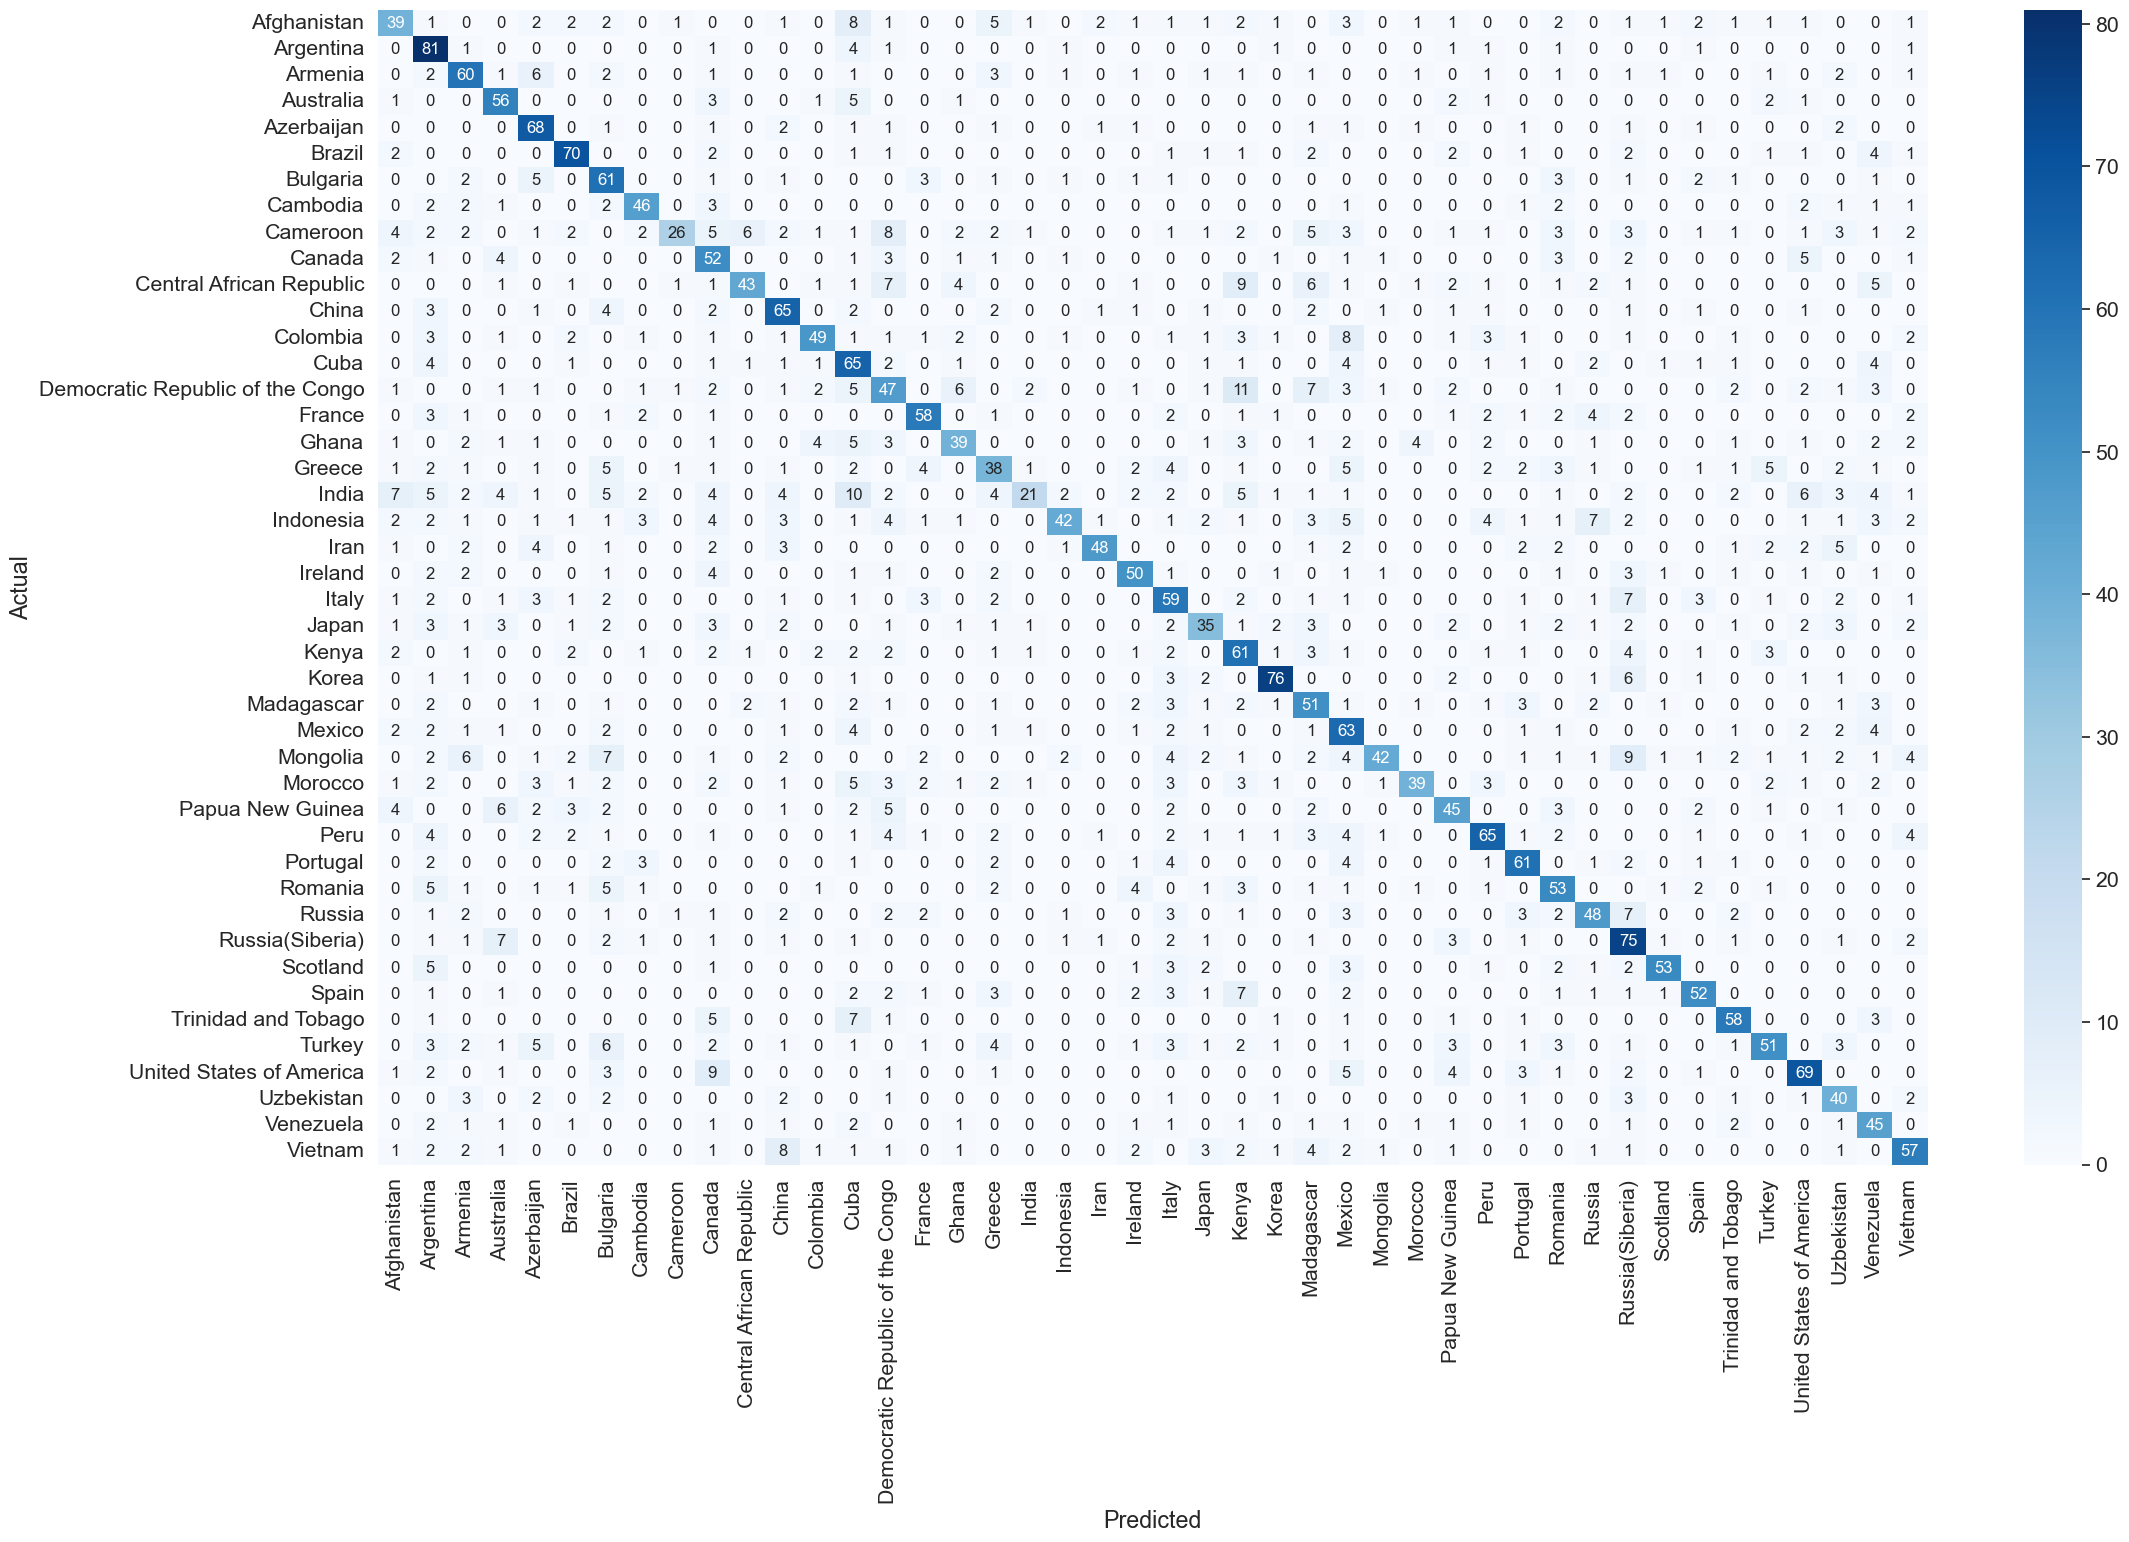

In [145]:
import seaborn as sns

class_names = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(25,15))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Experiment should be repeated for subregion and region categories. Performance of the best algorithm should also be tested on subsets of features (timbral, melodic, rhythmic and their combinations). Adjust category and appropriate subset of features at the beginning of *1. Evaluation of classifiers*. If the subset is loaded, go straight to hyperparameter optimization.  

# IV. Comparison 
Results were compared with Fang Zhou's dataset which is available under [this link](http://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music#). This dataset has geographical coordinates labels of  place of its origin. Prior to classification the coordinates were converted to countries (subregions and regions were added). Camparative dataset is available under [this link](https://drive.google.com/file/d/1HS9e9dDP9eDyLoreqBt-ozjeuNsRSN9H/view?usp=sharing)  


In [38]:
dataset_comparison = pd.read_csv(r'{path_to_dataset_comparison}\DATASET_comparison.csv') # fill path to comparative dataset

columns_to_drop = [-2, -3] # select two columns to drop: -1 (country), -2 (subregion), -3 (region)
dataset_comparison = dataset_comparison.drop(dataset_comparison.columns[columns_to_drop], axis=1)

# Select proper set of features:
X_comparison = dataset_comparison.iloc[:, :-1]  # all features
# X = data.iloc[:, :219] # timbre
# X = data.iloc[:, 219:291] # melody
# X = data.iloc[:, -26:-1] # rhythm
# X = data.iloc[:, :291] # timbre + rhythm
# X1 = data.iloc[:, :220]  # timbre + rhythm
# X2 = data.iloc[:, -26:-1]  # timbre + rhythm
# X = pd.concat([X1, X2], axis=1) # timbre + rhythm
# X = data.iloc[:, 220:-1] # melody + rhythm
y_comparison = dataset_comparison.iloc[:, -1]   

X_train_comparison, X_test_comparison, y_train_comparison, y_test_comparison = \
train_test_split(X_comparison, y_comparison, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_comparison = scaler.fit_transform(X_train_comparison)
X_test_comparison = scaler.transform(X_test_comparison)

In [40]:
best_country_classifier = rf_grid_search.best_estimator_
best_country_classifier.fit(X_train_comparison, y_train_comparison)
y_pred_comparison = best_country_classifier.predict(X_test_comparison)
test_accuracy_comparison = accuracy_score(y_test_comparison, y_pred_comparison)
print(f"Test set accuracy: {test_accuracy_comparison*100:.2f}%")

print(confusion_matrix(y_test_comparison, y_pred_comparison))
print(classification_report(y_test_comparison, y_pred_comparison))

Test set accuracy: 46.54%
[[ 3  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  2  0 ...  0 15  0]
 [ 0  0  0 ...  0  0  3]]
              precision    recall  f1-score   support

     Albania       0.50      0.75      0.60         4
    Algieria       0.12      0.25      0.17         8
   Australia       1.00      1.00      1.00         2
      Belize       0.60      0.75      0.67         4
      Brasil       0.27      0.33      0.30        12
  Cape Verde       0.25      0.11      0.15         9
       China       0.29      0.44      0.35         9
       Egypt       0.00      0.00      0.00         8
     England       1.00      0.67      0.80        12
    Ethiopia       0.40      0.75      0.52         8
     Georgia       0.70      0.78      0.74         9
      Greece       0.26      0.53      0.35        15
       India       0.25      0.32      0.28        22
   Indonesia       1.00      0.17      0.29         6
       

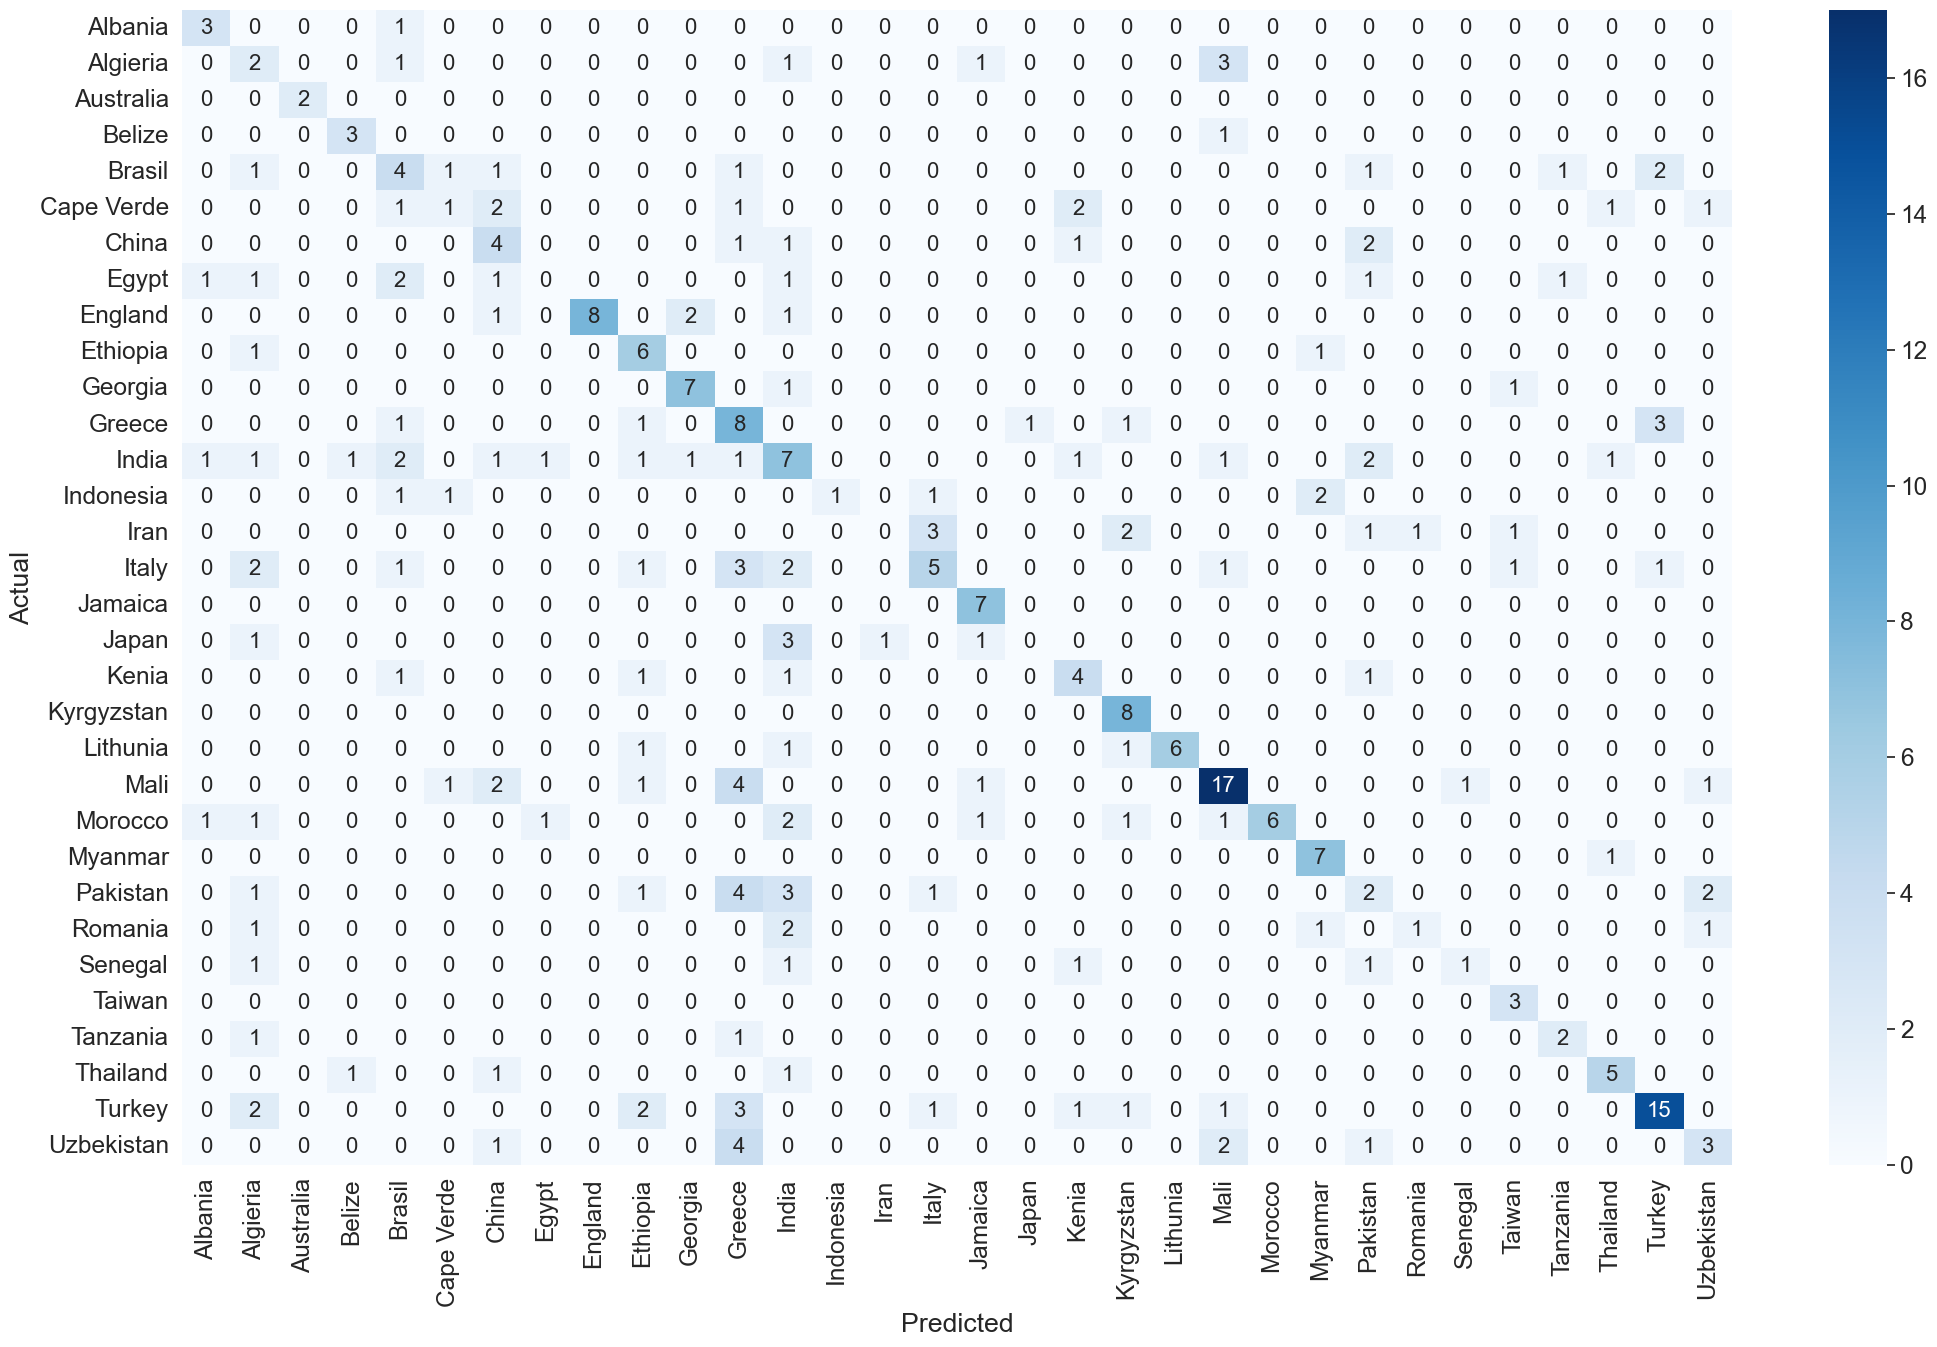

In [45]:
class_names_comparison = sorted(y_test_comparison.unique())
cm = confusion_matrix(y_test_comparison, y_pred_comparison)

plt.figure(figsize=(25,15))
sns.set(font_scale=1.6) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", 
            xticklabels=class_names_comparison, yticklabels=class_names_comparison)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Conclusion  
Dataset was tested using 10 different classifiers. After hyperparameter optimization Random Forest classifier achieved 60.19% of accuracy in predicting country of recordings origin. The best result for the comparative dataset was lower (46.54%) despite the fact that it had 11 class less. It was also imbalanced because some classes had very few examples.  
The results obtained in the experiment are satisfactory. In many cases the predictions consistent with ethnomusicological
assumptions, e.g. false positives occure mainly in the case of adjacent countries (USA & Canada or Mongolia & Russia (Siberia)). This may indicate that data and extracted features are correct.  
To achieve better results more examples should be collected. Moreover, feature extraction should be optimized (especially for polyphonic pieces).